## Preface
この Notebook は、[Election 2020: Benford’s Law/ベンフォードの法則は国家会計や参院選得票数でも成立しているか？](https://ggcs.io/2020/11/30/benfords-law-01/) 付録のPython scriptsの手順詳細版です。
- Website: ごたごた気流調査所 https://ggcs.io
- GitHub : Gota Gota Current Survey https://github.com/ggcurrs/gota2-observatory
- Version 1.1.0
- Created: 2020-12-03
- Updated: 2020-12-06

# Benford's law Set Generator: benford_table()
- 検査に使う桁数（引数）を与えると、{先頭 k 桁の数字の並び d: このパターンが出現する確率} を Dictionary として返します。
- 例として、k=1（先頭一桁）の場合の確率分布表を出力するようにしてあります。

In [1]:
import numpy as np


def benford_table(k=1):
    """Generates a dictionary of Benford's Set
    for the first k digit(s)"""
    # First k digit(s) as a key => Probability as a value
    benford_dict = {}
    lower, upper = 10 ** (k - 1), 10 ** k  # lower/upper bound of the bins.
    for d in range(lower, upper):
        benford_dict[d] = np.log10((d + 1) / d)

    return benford_dict


if __name__ == '__main__':
    bfd_dict = benford_table(1)  # Sample: first-digit table
    # Draw a table
    print('d', '\t', 'P(d)')
    for i in bfd_dict:
        print(i, '\t', f'{bfd_dict[i]:.5f}')


d 	 P(d)
1 	 0.30103
2 	 0.17609
3 	 0.12494
4 	 0.09691
5 	 0.07918
6 	 0.06695
7 	 0.05799
8 	 0.05115
9 	 0.04576


# Obtain source data from MIC, conv to a DataFrame: get_excel()
- サンプルとして、令和元年度決算書（一般会計歳出決算）をダウンロードして pandas.DataFrame にしておきます。
- なお、実験のたびに毎回新しいファイルをダウンロードするのも行儀が悪いので、Excel object を Excel file として作業ディレクトリに保存しておくことにし、必要があればこちらを使うことにします。

In [ ]:
import requests
import pandas as pd
from urllib.parse import urlparse
from pathlib import Path, PurePath


def get_excel(my_excel_url):
    """Downloads an Excel file and
    converts the first sheet to a pandas.DataFrame"""
    df = pd.read_excel(requests.get(my_excel_url).content)

    return df


if __name__ == '__main__':
    # [令和元年度決算書](https://www.bb.mof.go.jp/hdocs/bxss010br1a.html)
    STLMT_FY2019 = 'https://www.bb.mof.go.jp/server/2019/excel/DL201977001.xls'
    file_name = PurePath(urlparse(STLMT_FY2019).path).name

    dl_path = PurePath('.')
    file_path = dl_path.joinpath(file_name)

    if not Path(file_path).is_file():
        df_raw = get_excel(STLMT_FY2019)  # Downloads using the function.
        df_raw.to_excel(file_path, index=False)  # Backup the file.

    else:
        print(file_path, 'is already downloaded.')
        df_raw = pd.read_excel(file_path)

    print('DataFrame(df_raw) is ready')


# Implode the DataFrame into a list

## Check the DataFrame
- DataFrame(df_raw) の info() を取ると、Columns 9-14（Excel の K:P 列）に float がぎっしり詰まっているようなので、これを使うことにします。

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   主管                                   16 non-null     object 
 1   Unnamed: 1                           722 non-null    float64
 2   Unnamed: 2                           722 non-null    float64
 3   Unnamed: 3                           722 non-null    float64
 4   Unnamed: 4                           722 non-null    float64
 5   　　　 部・款・項・目                          34 non-null     object 
 6   Unnamed: 6                           68 non-null     object 
 7   Unnamed: 7                           206 non-null    object 
 8   Unnamed: 8                           414 non-null    object 
 9   歳入予算額 
                        (円)   738 non-null    int64  
 10  徴収決定済額 
                        (円)  738 non-null    int64  
 11  収納済歳入額 
                        

## Implode values in the selected DF columns to a list: df2list()
- List にして改めて数値を眺めると、ゼロや負の値も混ざっています。
- このままだと後でトラブルの原因になりそうなので、次のステップで 3 桁以上の正の整数だけを相手にすることにします。

In [ ]:
import numpy as np
import pandas as pd


# Implodes values in the selected DF columns to a list
def df2list(source_df, col_filter: list) -> list:
    """Extracts cell values from a DataFrame and list them."""
    df_filtered = source_df.iloc[:, col_filter]  # Filter for columns.

    array_filtered = np.array(df_filtered)  # Convert to numpy.ndarray
    # DataFrame(2D) to list(1D)
    row_size, col_size = array_filtered.shape  # (m, n) array to...
    value_list_length = row_size * col_size  # a list of m*n length.
    value_list = array_filtered.reshape(1, value_list_length).tolist()[0]

    return value_list


if __name__ == '__main__':
    columns_to_use = [9, 10, 11, 12, 13, 14]
    my_value_list = df2list(df_raw, columns_to_use)


# Confirm
print('\t', '\t'.join([i[:5] for i in df_raw.columns[columns_to_use]]))
for i in range(len(my_value_list)):
    print(f'{my_value_list[i]:>16}', end='')
    if i % len(columns_to_use) == len(columns_to_use)-1:
        print()


# Extract first n digit(s): head_hunter()
- Array 要素の数値から、指定番目の数字を取り出して dictionary にしておきます。
- ただし、3 桁未満の数値を分析してもあまり意味がないので、それらは filter して落とすことにします。
- 数字の取り出し方は、[Using Benford's Law to Detect Fraud](https://www.acfe.com/selfstudy.aspx?zid=2c92a0076a07e3be016a27279b1e2782)(ACFE) p.47 を参考にしていますが、最後の 'The last two digits test' は省略しました。
 - The first digit test
 - The second digit test
 - The first two digits test
 - The first three digits test
 - The last two digits test


In [ ]:
def head_hunter(input_array, cut_off=100):
    """Returns first n digit(s) from a list or 1D-np.array.
    Values less than cut_off value will be discarded."""
    filtered_array = list(filter(lambda x: x >= cut_off, input_array))
    print('Length of in/out array:', len(input_array), len(filtered_array))

    heads_dict = {
        'first_one_digit': [int(str(int(i))[0]) for i in filtered_array],
        'second_md_digit': [int(str(int(i))[1]) for i in filtered_array],
        'first_two_digits': [int(str(int(i))[:2]) for i in filtered_array],
        'first_thr_digits': [int(str(int(i))[:3]) for i in filtered_array]
        # 'last_two_digits': [int(str(int(i))[-2:]) for i in filtered_array]
    }

    return heads_dict  # Comprises four lists above.


if __name__ == '__main__':
    my_first_one_digit = head_hunter(my_value_list)['first_one_digit']
    my_first_two_digits = head_hunter(my_value_list)['first_two_digits']
    my_first_thr_digits = head_hunter(my_value_list)['first_thr_digits']
    # Confirm
    # print(my_first_one_digit)
    # print(my_first_two_digits)
    # print(my_first_thr_digits)


# Presentation

## Prepare Histogram Data: bfd_hist()
- Array に含まれる値を Benford's law の分布（density=True）を階級（bins）にしたがって整理します。

In [ ]:
import numpy as np


def bfd_hist(input_array) -> np.array:
    """Groups the data in the input_array into bins"""
    # Check the integrity of the input_array.
    digit_min = int(np.log10(min(input_array)) + 1)
    digit_max = int(np.log10(max(input_array)) + 1)
    if digit_min == digit_max:  # of digits must be the same.
        digit = digit_max
        print('OK: An array of',
              str(digit) + '-digit numbers is passed to the function.')
        # Define bin boundaries.
        lower, upper = 10 ** (digit - 1), 10 ** digit
        hist, bin_edges = np.histogram(input_array,
                                       bins=range(lower, upper + 1),
                                       density=True
                                       )
        bfd_hist, bfd_bins = hist, bin_edges[:-1]  # of bins = eds-1

        return bfd_hist, bfd_bins

    else:
        print('Error: Illegal array')


if __name__ == '__main__':
    my_fone_hist, my_fone_bins = bfd_hist(my_first_one_digit)
    my_ftwo_hist, my_ftwo_bins = bfd_hist(my_first_two_digits)
    my_fthr_hist, my_fthr_bins = bfd_hist(my_first_thr_digits)


## Prepare Summary Tables

The first/first two/first three digits test のそれぞれについて、先頭 k 桁の値（d）、Benford's law で計算した確率（P(d)）、実測値、Deviation を column として pandas.DataFrame に整理しておきます。


In [7]:
# The first digit test
number_of_digits = 1
table_dict = benford_table(number_of_digits)

df_STLMT_FY2019_fone_test = pd.DataFrame(
    {
        'First Digit': table_dict.keys(),
        'Benford\'s Set': table_dict.values(),
        'Data Set X': my_fone_hist,
        'Deviation': np.array(list(table_dict.values())) - my_fone_hist
    }
)

# The first two digits test
number_of_digits = 2
table_dict = benford_table(number_of_digits)

df_STLMT_FY2019_ftwo_test = pd.DataFrame(
    {
        'First Two Digits': table_dict.keys(),
        'Benford\'s Set': table_dict.values(),
        'Data Set X': my_ftwo_hist,
        'Deviation': np.array(list(table_dict.values())) - my_ftwo_hist
    }
)

number_of_digits = 3
table_dict = benford_table(number_of_digits)

df_STLMT_FY2019_fthr_test = pd.DataFrame(
    {
        'First Three Digits': table_dict.keys(),
        'Benford\'s Set': table_dict.values(),
        'Data Set X': my_fthr_hist,
        'Deviation': np.array(list(table_dict.values())) - my_fthr_hist
    }
)


# Confirm
print('\n', df_STLMT_FY2019_fone_test)
print('\n', df_STLMT_FY2019_ftwo_test)
print('\n', df_STLMT_FY2019_fthr_test)


    First Digit  Benford's Set  Data Set X  Deviation
0            1       0.301030    0.309591  -0.008561
1            2       0.176091    0.167137   0.008954
2            3       0.124939    0.131171  -0.006232
3            4       0.096910    0.087447   0.009463
4            5       0.079181    0.079337  -0.000156
5            6       0.066947    0.062412   0.004535
6            7       0.057992    0.059591  -0.001599
7            8       0.051153    0.058181  -0.007028
8            9       0.045757    0.045134   0.000623

     First Two Digits  Benford's Set  Data Set X  Deviation
0                 10       0.041393    0.041255   0.000137
1                 11       0.037789    0.049365  -0.011577
2                 12       0.034762    0.053597  -0.018835
3                 13       0.032185    0.027856   0.004329
4                 14       0.029963    0.017983   0.011980
..               ...            ...         ...        ...
85                95       0.004548    0.003173   0.0

# Draw the Charts

Text(0.5, 1.0, 'The First Three Digits Test ')

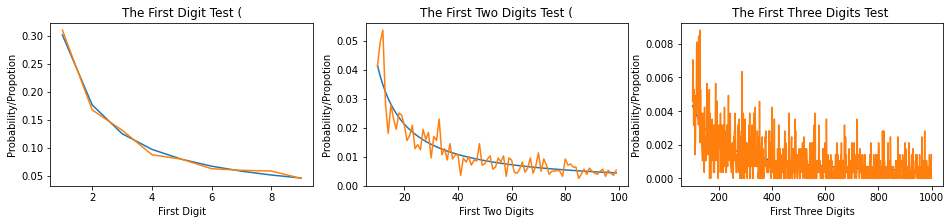

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 3))

plt.subplot(131)
fone = df_STLMT_FY2019_fone_test
plt.plot(fone['First Digit'], fone[['Benford\'s Set', 'Data Set X']])
plt.xlabel('First Digit')
plt.ylabel('Probability/Propotion')
plt.title('The First Digit Test (')

plt.subplot(132)
ftwo = df_STLMT_FY2019_ftwo_test
plt.plot(ftwo['First Two Digits'], ftwo[['Benford\'s Set', 'Data Set X']])
plt.xlabel('First Two Digits')
plt.ylabel('Probability/Propotion')
plt.title('The First Two Digits Test (')

plt.subplot(133)
fthr = df_STLMT_FY2019_fthr_test
plt.plot(fthr['First Three Digits'], fthr[['Benford\'s Set', 'Data Set X']])
plt.xlabel('First Three Digits')
plt.ylabel('Probability/Propotion')
plt.title('The First Three Digits Test ')
